In [334]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [336]:
# Loading the train data
data = pd.read_csv('/content/drive/My Drive/Sales Forecasting using Linear Regression/train.csv')

In [337]:
data.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [338]:
# Checking for null values
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


,0
date,0
store,0
item,0
sales,0


In [339]:
# Dropping store and item columns
data.drop(['store', 'item'], axis=1, inplace=True)

In [340]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [341]:
# converting date from objects datatype to dateTime datatype
data['date'] = pd.to_datetime(data['date'])

In [342]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [343]:
data.reset_index(inplace=True)

print(data.columns)

Index(['index', 'date', 'sales'], dtype='object')


In [344]:
# Converting 'date' to a monthly period and add it as a new column
data['date'] = data['date'].dt.to_period('M')

# Grouping by the 'month' column and calculate the sum of sales for each month
monthly_sales = data.groupby('date')['sales'].sum().reset_index()

# Checking the result
print(monthly_sales.head())


      date   sales
0  2013-01  454904
1  2013-02  459417
2  2013-03  617382
3  2013-04  682274
4  2013-05  763242


In [345]:
# converting the retulting date column to timestamp datatype
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [346]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


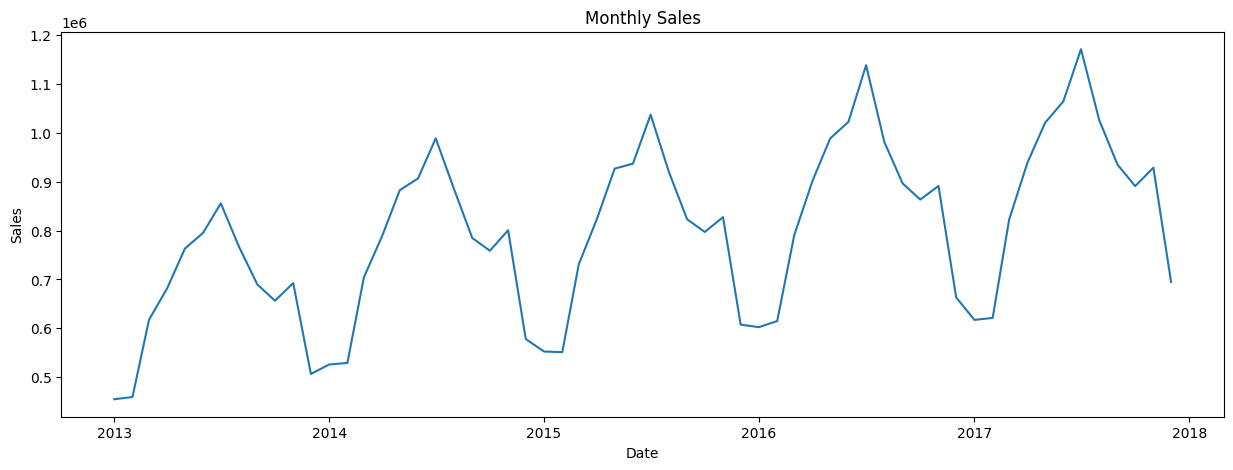

In [347]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales')
plt.show()

In [348]:
# Calling the difference on the sales columns to make the sales data stationary

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


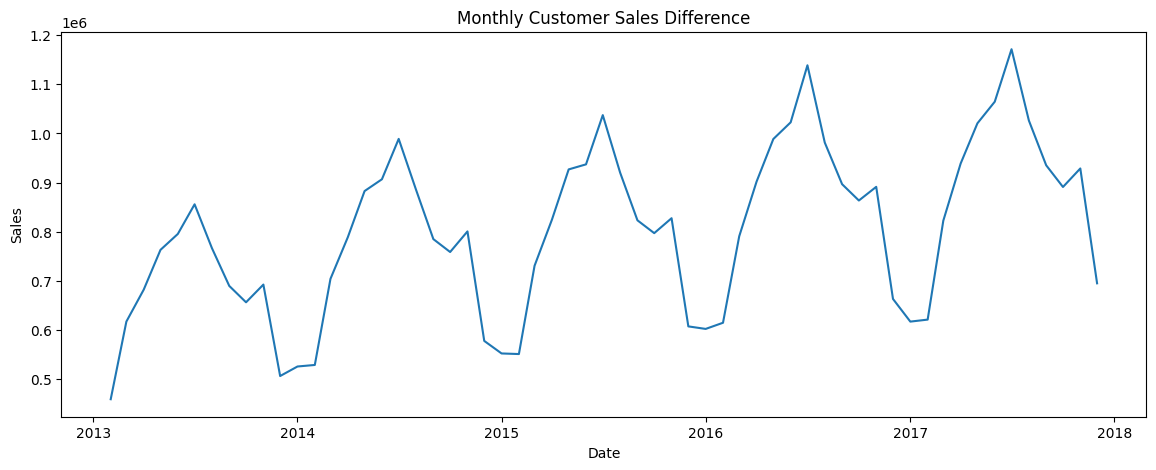

In [349]:
plt.figure(figsize=(14, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales Difference')
plt.show()

In [350]:
# Creating sales_diff column
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()

# Dropping rows with NaN values (first row will have NaN due to diff())
supervised_data = monthly_sales.dropna().reset_index(drop=True)

# Adding lagged features (up to 12 months or less if data is limited)
max_lag = min(12, len(supervised_data) - 1)  # Ensure we don't create lags beyond available data

for i in range(1, 13):
    supervised_data['month_' + str(i)] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)


# Dropping NaN values after shifting
supervised_data = supervised_data.dropna().reset_index(drop=True)

# Dropping 'date' and 'sales' columns
supervised_data = supervised_data.drop(['date', 'sales'], axis=1)

# Checking the result
print(supervised_data.head(10))

   sales_diff   month_1   month_2   month_3   month_4   month_5   month_6  \
0    175184.0    3130.0   19380.0 -186036.0   36056.0  -33320.0  -76854.0   
1     84613.0  175184.0    3130.0   19380.0 -186036.0   36056.0  -33320.0   
2     93963.0   84613.0  175184.0    3130.0   19380.0 -186036.0   36056.0   
3     23965.0   93963.0   84613.0  175184.0    3130.0   19380.0 -186036.0   
4     82168.0   23965.0   93963.0   84613.0  175184.0    3130.0   19380.0   
5   -103414.0   82168.0   23965.0   93963.0   84613.0  175184.0    3130.0   
6   -100472.0 -103414.0   82168.0   23965.0   93963.0   84613.0  175184.0   
7    -26241.0 -100472.0 -103414.0   82168.0   23965.0   93963.0   84613.0   
8     41900.0  -26241.0 -100472.0 -103414.0   82168.0   23965.0   93963.0   
9   -222735.0   41900.0  -26241.0 -100472.0 -103414.0   82168.0   23965.0   

    month_7   month_8   month_9  month_10  month_11  month_12  
0  -89161.0   60325.0   32355.0   80968.0   64892.0  157965.0  
1  -76854.0  -89161.0   

In [351]:
print(monthly_sales['date'].min())
print(monthly_sales['date'].max())

2013-02-01 00:00:00
2017-12-01 00:00:00


# **Splitting data into Train and Test**

In [352]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: (34, 13)
Test Data Shape: (12, 13)


In [353]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_data)
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [354]:
x_train, y_train = train_data[:, 1:], train_data[:, 0:1]
x_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

x_train.shape =  (34, 12)
y_train.shape =  (34,)
x_test.shape =  (12, 12)
y_test.shape =  (12,)


In [355]:
# Making prediction data frame to merge the predicted sales prices of all trained algs
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [356]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [357]:
# Creating the linear regression model, and predicted output
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [358]:
lr_pre = lr_pre.reshape(-1, 1)
# This is a set matrix -p contains the input features of the test data, also the predicted output
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [359]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_test_set = pd.Series(result_list, name='Linear Prediction')
predict_df = predict_df.merge(lr_pre_test_set, left_index=True, right_index=True)

In [360]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.478752e+05
1  2017-02-01       6.296918e+05
2  2017-03-01       8.197435e+05
3  2017-04-01       9.433828e+05
4  2017-05-01       1.033676e+06
5  2017-06-01       1.065058e+06
6  2017-07-01       1.201530e+06
7  2017-08-01       1.001867e+06
8  2017-09-01       9.412975e+05
9  2017-10-01       9.081158e+05
10 2017-11-01       9.163515e+05
11 2017-12-01       6.948589e+05


In [361]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  16308.946774591575
Linear Regression MAE:  12518.32186372774
Linear Regression R2:  0.9904861543406625


# **Visualization of the prediction against actual sales**

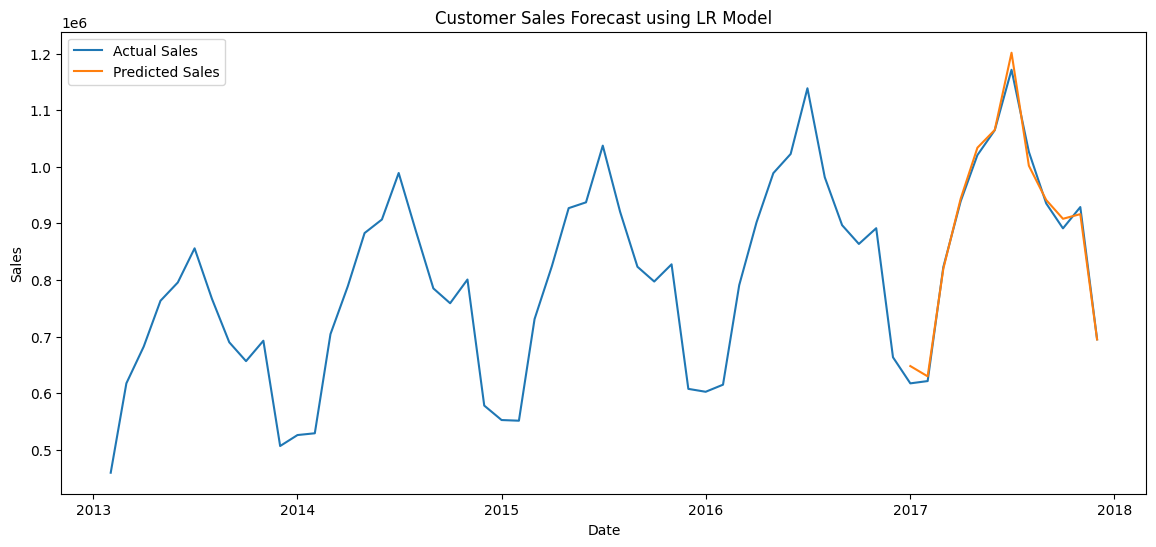

In [362]:
# Setting the figure size to make it wider
plt.figure(figsize=(14, 6))
# Actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.title('Customer Sales Forecast using LR Model')

# Displaying the plot
plt.show()